# Example notebook for Proteus operations

### Author

Boris Nedyalkov, Quantum Computing Lab, IFAE, Barcelona

#### **In this notebook you will learn how to:**

* Import all the libraries one needs
* Set the working parameters of the machine
* Initialize the machine
* Create waveforms
* Download the waveforms to the Proteus
* Create a tasktable (sequences of pulses)
* Readout the signal [==UNDER DEVELOPEMENT==]
* Process the signal readout data [==UNDER DEVELOPEMENT==]

### Import some generic libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import os

srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)

# These are the Tabor developers' libraries, they allow us to I/O interface with the Proteus
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst

### Import our homemade libraries

In [2]:
import initializers  # this library contains intialization functions for the Proteus 

import pulse_lib # this library contains all the types of pulses, one can add here a new type of pulse if needed
import tasks # this library contains all the types of basic tasks, new ones can be added if need arises
import readers # this library contains all the readout functions

import helpers # this library contains auxillary functions

### Set the parameters of the machine

In [47]:
SCLK = 2.25e9 # sampling clock rate of the generator (AWG) ## max value 9e9
DUC_INTERP = 1  ### the DUC interpolator mode
DIG_SCLK = 2.25e9 # sampling clock rate of the digitizer (DAC) ## max value 2.7e9

SOURCE_NCO = 1e7   
DDC_NCO = 1e7 # make the same as Source NCO

### Initialize the machine

In [4]:
# get the DAC mode, range, Serial port #, the data type of the system (8 or 16bit), and the instrument handle
dac_mode, max_dac, sid, data_type, inst = initializers.connection_func() # Make sure the Model name is P9484M, that the name of our module


=========CONNECTING=========
process id 10708
Connected to: Tabor Electronics,P9484M,000000220642,1.223.0
Model: P9484M
===CONNECTION ESTABLISHED===

===SYSTEM'S INFORMATION===
DAC waveform format: 16 bits-per-point
Max DAC wave-point level: 65535
Half DAC wave-point level: 32767.0
Number of channels: 4
Max segment number: 65536
Available memory per DDR: 8,581,545,984 wave-bytes
==========READY============


### Initialize the channels

In [5]:
# initialize channel 1
channel_numb = 1
initializers.initialization_func(channel_numb, inst, SCLK)

# # initialize all the channels
# for i in range(0,4):  
#     channel_numb = i + 1
#     initializers.initialization_func(channel_numb, inst, SCLK) 


===INITIALIZATION OF CHANNEL 1===  -->  ===DONE===
ERRORS: 0, no error


### Define some pulse shapes

In [6]:
pulse = pulse_lib.Pulse(SCLK, DUC_INTERP, show_plot = True)

Defining the sinus and the blank signal. After that we convert them to 16bit numbers (the Proteus takes its input in that format)

Note: A !WARNING! message may come if the data chunk representing the form doesn't have the right length of bytes.
An automatic script to convert it to the closest right length will engage and fix this. The resulting length of the waveform in bytes will be given after.

original seglen: 25000.0

!WARNING! The segment of the defined signal (25000.0 points) does not comply with the format of the possible data chunk for a signal, which is ||| datalength = ( 64 * (32 + n)) |||, where         n is an integer.
-----------Will edit the signal automatically to suit the # of points-----------

formated seglen: 24960
The blank singnal is with time width: 8.192e-07


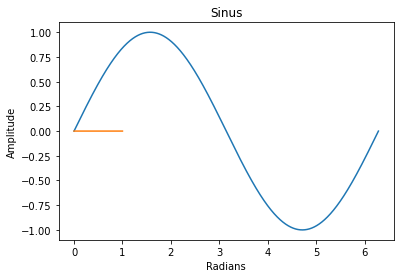

In [7]:
# sin_f = pulse.simple_sin(amplitude = 1, frequency = 100000)  ### creating a sinus shape, frequency is in Hz

# blank = pulse.blank_signal()

# sin_f = helpers.digital_conv_func(sin_f, max_dac, data_type) ### converting the signal from float format array to a binary format array
# blank = helpers.digital_conv_func(blank, max_dac, data_type)

@ Defining the parameters and creating a gaussian pulse. After that we convert the signal array to 16bit format (the Proteus takes its input in that format)

period = 1000.0[ns]
sigma = 3400.0[ns]
sigma_num = 8500.0 datapoints 
5 8500.0 42500.0
Gaussian Segement length = 42500 datapoints

Gaussian Segement length (in time) = 17000.0 [ns]]

!WARNING! Sigma is comparable to the period of the oscillation


!WARNING! The segment of the defined signal (42500 points) does not comply with the format of the possible data chunk for a signal, which is ||| datalength = ( 64 * (32 + n)) |||, where         n is an integer.
-----------Will edit the signal automatically to suit the # of points-----------

Gaussian frequency = 1.0[Mhz]


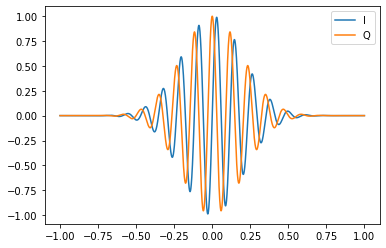

In [8]:
frequency = 1e6 ### frequency of the oscillation
sigma = 340e-08  ### make it bigger then the period of the oscillation 
width_over_sigma = 5    # time width of the gaussian pulse, a.k.a. how many sigmas wide is the pulse, for example - width = [5*sigma], by 
amplitude = 1

gauss_signal_i_init, gauss_signal_q_init, tot, gauss_signal_envelope_init = pulse.gaussian_pulse (amplitude, 
                                                                                                  sigma, 
                                                                                                  width_over_sigma, 
                                                                                                  frequency)

gauss_signal_i = helpers.digital_conv_func(gauss_signal_i_init, max_dac, data_type)

In [9]:
inter_array = np.empty(2*len(gauss_signal_envelope_init))

for i in range(0, len(gauss_signal_envelope_init)):
    inter_array[0+i*2] = gauss_signal_envelope_init[i]
    inter_array[1+i*2] = 0

    
inter_array2 = np.empty(len(gauss_signal_i_init) + len(gauss_signal_q_init))

for i in range(0, len(gauss_signal_i_init)):
    inter_array2[0+i*2] = gauss_signal_i_init[i]
    inter_array2[1+i*2] = gauss_signal_q_init[i]


print(inter_array)
len(inter_array)
inter_array = helpers.digital_conv_func(inter_array, max_dac, data_type)
inter_array2 = helpers.digital_conv_func(inter_array2, max_dac, data_type)

[3.72555408e-06 0.00000000e+00 3.72993915e-06 ... 0.00000000e+00
 3.72993915e-06 0.00000000e+00]


In [10]:
##### TEST IQ
I = np.linspace (1,1,10000)
Q = I*0

inter_array3 = np.empty(len(I) + len(Q))
for i in range(0, len(I)):
    inter_array3[0+i*2] = I[i]
    inter_array3[1+i*2] = Q[i]
    
inter_array3 = helpers.digital_conv_func(inter_array3, max_dac, data_type)

In [11]:
inter_array3

array([65534, 32767, 65534, ..., 32767, 65534, 32767], dtype=uint16)

@ Same thing but with the sinus pulse

period = 1000.0[ns]
Sine segement length = 32499 datapoints

Sine segement length (in time) = 13000.0 [ns]]

!WARNING! The segment of the defined signal (32499 points) does not comply with the format of the possible data chunk for a signal, which is ||| datalength = ( 64 * (32 + n)) |||, where         n is an integer.
-----------Will edit the signal automatically to suit the # of points-----------

Signal frequency = 1.0[Mhz]


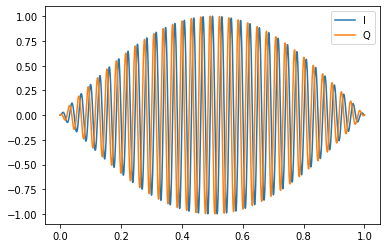

In [12]:
frequency = 1e6 ### frequency of the oscillation
width = 13e-6
amplitude = 1

sin_signal_i = pulse.sin_pulse (amplitude, width, frequency)[0]

sin_signal_i = helpers.digital_conv_func(sin_signal_i, max_dac, data_type)

### Downloading some wave shapes onto the Proteus

In [13]:
# wave = gauss_signal_i
# wave2 = sin_f
# wave3 = blank
# wave4 = sin_signal_i
# wave5 = inter_array
# wave6 = inter_array2
wave7 = inter_array3

In [14]:
# initialize the channel
channel_numb = 1
initializers.initialization_func(channel_numb, inst, SCLK)


===INITIALIZATION OF CHANNEL 1===  -->  ===DONE===
ERRORS: 0, no error


In [48]:
#FIRST CHANNEL SETTINGS
inst.send_scpi_cmd('INST:CHAN 1') # instantiate channel 1
inst.send_scpi_cmd(':TRAC:DEL:ALL') # delete unnecessary old data
inst.send_scpi_cmd(':SOUR:MODE DUC') # start in DUX mode (this wiil enable interpolation and IQ mixing)
inst.send_scpi_cmd(':SOUR:INT X8') # set Proteus to interpolation X8.
inst.send_scpi_cmd(':SOUR:IQM ONE') # set modulation to IQ Modulation type ONE

#---------------------------------------------------------------------
#Play selected segment in selected channel and set amplitude
#---------------------------------------------------------------------
#Set sampling rate for the AWG
inst.send_scpi_cmd(':FREQ:RAST {0}'.format(SCLK))
inst.send_scpi_cmd(':NCO:CFR1 {0}'.format(SOURCE_NCO)) # set NCO frequency of CH1 to some value  !!!! USE THE SAME IN THE DDC CFR1
inst.send_scpi_cmd(':VOLT MAX')
inst.send_scpi_cmd(':NCO:SIXD1 ON')

0

@ When we download the signal onto the proteus we choose a segment number to assign to it, by this number we will refer to the signal later.

In [44]:
# download signal to an approprate 'channel' and 'segment of the channel'
# helpers.download_func (inst, wave, channel = 1, segment = 1)
# helpers.download_func (inst, wave2, channel = 1, segment = 2)
# helpers.download_func (inst, wave3, channel = 1, segment = 3)
# helpers.download_func (inst, wave4, channel = 1, segment = 4)
# helpers.download_func (inst, wave5, channel = 1, segment = 5)
# helpers.download_func (inst, wave6, channel = 1, segment = 6)
helpers.download_func (inst, wave7, channel = 1, segment = 7)

wave size: 20000
0, no error


### Let us now define a tasktable (as sequence of pulses and actions)

In [45]:
task = tasks.Task(inst)

In [49]:
channel = 1
segment_number = 7

task.solid_task(inst, channel, segment_number)
helpers.start_task(inst, channel)

0, no error
0, no error


In [41]:
def digitizer_setup(DIG_SCLK, time_delay):

    inst.send_scpi_cmd(':DIG:MODE DUAL')
    inst.send_scpi_cmd(':DIG:CHAN:RANGe HIGH')

    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)


    # set the sampling rate for the Digitizer (or ADC)
    inst.send_scpi_cmd(':DIG:FREQ {0}'.format(DIG_SCLK))

    # Set DDC mode to complex
    resp = inst.send_scpi_cmd(':DIG:DDC:MODE COMP')
    print(resp)

    resp = inst.send_scpi_cmd(':DIG:DDC:DEC X16')
    print(resp)

    resp = inst.send_scpi_query(':DIG:DDC:CLKS DIG')  # !!! doesn't work, must be "...CLKS AWG"
    print(resp)

    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)

    ###########################################

    #This is to be used only for mode COMPLEX (not mode REAL)
    # Set center frequency of channel 1 to 100MHz  
    # DDC_NCO = 1e9   # !!!!! use the frequency of you pulse here !!!!!
    inst.send_scpi_cmd(':DIG:DDC:CFR1 {0}'.format(DDC_NCO))

    ###########################################

    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)

    # Enable capturing data from channel 1
    inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
    inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')

    # # Select the internal-trigger as start-capturing trigger:
    # inst.send_scpi_cmd(':DIG:TRIG:SOURCE CPU') 

    # Select the task trigger as start-capturing trigger:
    inst.send_scpi_cmd(':DIG:TRIG:SOURCE TASK1')

    # Set Trigger AWG delay to 0
    inst.send_scpi_cmd(':DIG:TRIG:AWG:TDEL {0}'.format(time_delay))  ##!!! Don't know if it should be like this

    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)
    
    return None
    
time_delay=0
digitizer_setup(DIG_SCLK, time_delay)

0, no error
0
0

0, no error
0, no error
0, no error


In [23]:
# Allocate four frames of 4800 samples
numframes, framelen = 1, 10*4800
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)

# Select which frames are filled with captured data (all frames in this example)
inst.send_scpi_cmd(':DIG:ACQ:FRAM:CAPT:ALL');

# clean memory
inst.send_scpi_cmd(':DIG:ACQ:ZERO:ALL')

resp = inst.send_scpi_cmd(':DIG:DATA:FORM?')
print (resp)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

resp = inst.send_scpi_query(':DIG:DDC:DEC?')  # try with this maybe
print(resp)

0
0, no error
X16


# DSP Setup

In [24]:
# # Select to store the IQ data
# inst.send_scpi_cmd(':DSP:STOR1 DIRect1')
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

# # Set IQ PATH Input to AMPH
# inst.send_scpi_cmd(':DSP:DEC:IQP:SEL 1')
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

# inst.send_scpi_cmd(':DSP:DEC:IQP:INP AMPH')
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

# # Set Decision frame size 50 points
# inst.send_scpi_cmd(':DSP:DEC:FRAM {0}'.format(50))
# resp = inst.send_scpi_query(':SYST:ERR?')
# print(resp)

In [25]:
# # Clean memory 
# inst.send_scpi_cmd(':DIG:ACQ:ZERO:ALL')  ## !!!! try with and without this, when everything is running OK
# time.sleep(1)

# Stop the digitizer's capturing machine (to be on the safe side)
inst.send_scpi_cmd(':DIG:INIT OFF')
time.sleep(0.1)

# Start the digitizer's capturing machine ###################### START CAPTURE
inst.send_scpi_cmd(':DIG:INIT ON')

for i in range (1,100):
    delta_t = 1/100
    time.sleep(delta_t) # if we wait long enough time the machine captures a signal
    resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STAT?')
    if resp[6:] == '1':  # maybe 1 comes as a float, check it
        print('Response:',resp, 'Time:',delta_t*i)
        break

        
# Stop the digitizer's capturing machine (to be on the safe side) ################# STOP CAPTURE
inst.send_scpi_cmd(':DIG:INIT OFF')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Response: 1,1,0,1 Time: 0.01
0, no error


In [26]:
# Choose what to read 
# (only the frame-data without the header in this example)
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')

# Choose which frames to read (all in this example)
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')

# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total size in bytes: ' + resp)
print()

# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')

#wavlen = num_bytes // 2
wavlen = num_bytes // 4  # for the DUC mode !!!!!

#wav1 = np.zeros(wavlen, dtype=np.uint16)
wav1 = np.zeros(wavlen, dtype=np.uint32) # for the DUC mode !!!!!

rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)

# # Read the data that was captured by channel 2:
# inst.send_scpi_cmd(':DIG:CHAN:SEL 2')

# wav2 = np.zeros(wavlen, dtype=np.uint16)
# rc = inst.read_binary_data(':DIG:DATA:READ?', wav2, num_bytes)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Total size in bytes: 192000

0, no error


In [27]:
# Plot the samples
totlen = int(numframes * framelen /2)
x = range(totlen)

wave_i = np.zeros(totlen, dtype=np.int32)
wave_q = np.zeros(totlen, dtype=np.int32)


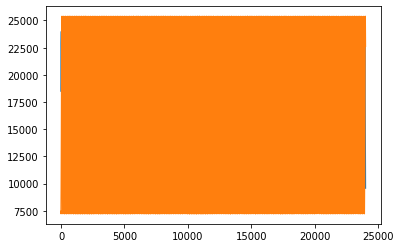

In [28]:
wave_i = wav1[::2]
wave_q = wav1[1::2]

plt.plot(x, wave_i, '-',x, wave_q, '-')

In [29]:
wave_i = wave_i.astype('int32')
wave_q = wave_q.astype('int32')

In [30]:
wave_i = wave_i - 16384
wave_q = wave_q - 16384

In [31]:
wave_i

array([ 2130,  2587,  3000, ..., -6717, -6757, -6792])

In [32]:
len(wav1)

48000

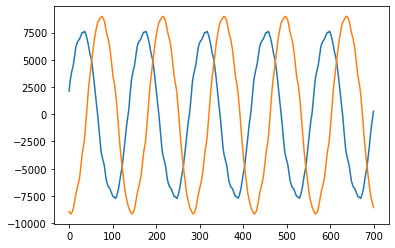

In [36]:
plt.plot(wave_i[0:700], '-', wave_q[0:700], '-')

In [34]:
#########################################

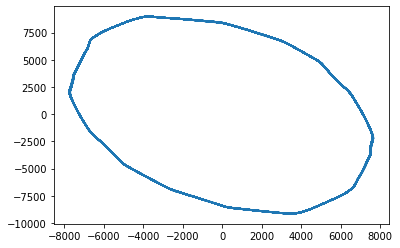

In [35]:
plt.plot (wave_i, wave_q)

In [11]:
admin = TepAdmin()  ### decalring a shortcut to send SCPY commands to the machine
inst = admin.open_instrument(slot_id=sid)  ### decalring a shortcut to send SCPY commands to the machine

inst.close_instrument()
admin.close_inst_admin()

# ml.quitter(sid)

0